In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/luis/.virtualenvs/domino/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
import sys
sys.path.insert(1, '../domino/libs')
sys.path.insert(1, '../domino')
sys.path.insert(1, '/home/earendil/Documents/MyLib')

#style.use('/home/earendil/Documents/MyLib/big_plt_style.mplstyle')

import pandas as pd

from libs.utilities import domino_mysql_server, read_mysql

/home/luis/.virtualenvs/domino/lib/python3.5/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


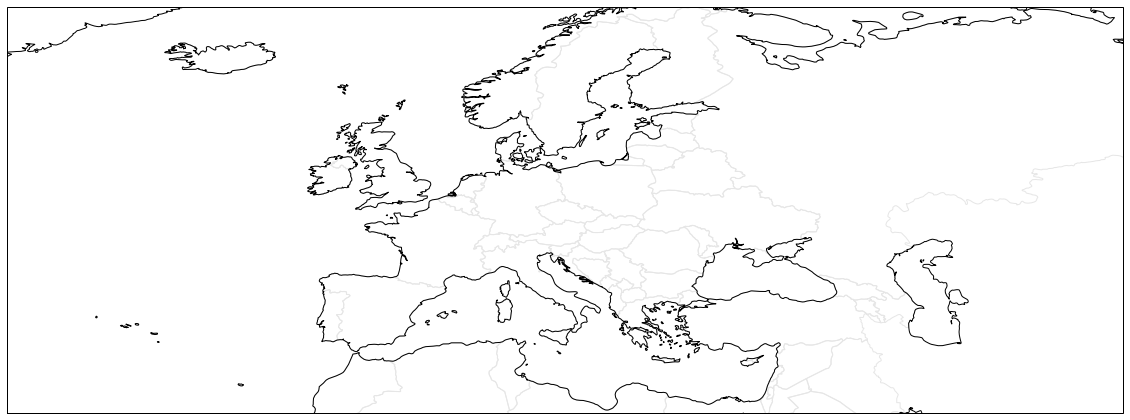

In [2]:
from cartopy.io import shapereader
import numpy as np
import geopandas
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

# get natural earth data (http://www.naturalearthdata.com/)

# get country borders
resolution = '50m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# read the german borders
poly = df.loc[(df['CONTINENT'] == 'Europe') | 
              ((df['CONTINENT']=="Africa") &
               (df['SUBREGION']=="Northern Africa") | 
              ((df['CONTINENT']=="Asia") &
               (df['SUBREGION']=="Western Asia")))]['geometry']#.values[0]


fig=plt.figure(figsize=(20, 15))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_geometries(poly, crs=ccrs.PlateCarree(), facecolor='none', 
                  edgecolor='0.9')

ax.coastlines(resolution='50m')

ax.set_extent([-40, 70, 30, 70], crs=ccrs.PlateCarree())

plt.show()

 ## MAPS O-D PAIR AND DEMAND BETWEEN ROUTES

In [167]:
od = [('UKBB','UACC'),('LEBL','EGLL')]
#od = [('LEBL','EGLL')]
od = [('UKBB','UACC')]
lod = ["r.icao_orig=\""+t[0]+"\" and r.icao_dest=\""+t[1]+"\"" for t in od]
airports = ""
for l in lod:
    airports += (l + " or ")
    


# Get model output
with domino_mysql_server(profile='remote_direct') as connection:
    query = "select r.id, r.icao_orig, r.icao_dest, r.fp_distance_km, sequence, \
    ST_X(entry_point) as lat_entry, ST_Y(entry_point) as lon_entry, \
    ST_X(exit_point) as lat_exit, ST_Y(exit_point) as lon_exit \
    from route_pool r \
    join route_pool_has_airspace_static rphas on rphas.route_pool_id=r.id \
    where "+airports[:-4]

    df_orig = read_mysql(query=query, engine=connection['engine'])
    
    
df=df_orig[['id','icao_orig','icao_dest','sequence','fp_distance_km','lat_entry','lon_entry']].rename(columns={'lat_entry':'lat','lon_entry':'lon'}).append(
df_orig[['id','icao_orig','icao_dest','sequence','fp_distance_km','lat_exit','lon_exit']].rename(columns={'lat_exit':'lat','lon_exit':'lon'})).drop_duplicates().sort_values(['id','sequence'])   

DB connection to 127.0.0.1 with ssh tunneling through archdb.fst.westminster.ac.uk


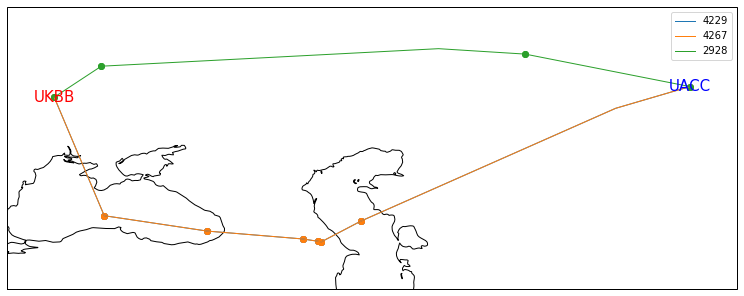

In [168]:
import cartopy.crs as ccrs


scale = 5

for ia,row in df[['icao_orig','icao_dest']].drop_duplicates().iterrows():
    d_coords_route_pool = df[(df['icao_orig']==row[0]) & (df['icao_dest']==row[1])]
    
    unique_id = d_coords_route_pool['id'].drop_duplicates()
    

    min_lon = min(d_coords_route_pool['lon'])
    max_lon = max(d_coords_route_pool['lon'])
    min_lat = min(d_coords_route_pool['lat'])
    max_lat = max(d_coords_route_pool['lat'])
    
    fig=plt.figure(ia,figsize=(2.61538461538*scale, 3*scale))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([min_lon-3,max_lon+3,min_lat-3,max_lat+3],
                 crs=ccrs.PlateCarree())
    ax.coastlines(resolution='50m')

    for i in unique_id:
        ax.plot(d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lon'],
                 d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lat'], linewidth=1,
                 transform=ccrs.Geodetic(),
                label=list(d_coords_route_pool.loc[d_coords_route_pool['id']==i,'fp_distance_km'].drop_duplicates())[0]
                 )

        ax.scatter(d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lon'],
                 d_coords_route_pool.loc[d_coords_route_pool['id']==i,'lat'], linewidth=1,
                 transform=ccrs.Geodetic(),
                   label=''
                 )

    ax.text(list(df_orig[(df_orig['sequence']==1)][['lat_entry','lon_entry']].drop_duplicates()['lon_entry'])[0],
        list(df_orig[(df_orig['sequence']==1)][['lat_entry','lon_entry']].drop_duplicates()['lat_entry'])[0],
        list(df_orig[(df_orig['sequence']==1)][['icao_orig']].drop_duplicates()['icao_orig'])[0],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15, color='red',
        transform=ccrs.Geodetic())
    
    ax.text(list(df_orig[(df_orig['sequence']==max(df_orig['sequence']))][['lat_exit','lon_exit']].drop_duplicates()['lon_exit'])[0],
        list(df_orig[(df_orig['sequence']==max(df_orig['sequence']))][['lat_exit','lon_exit']].drop_duplicates()['lat_exit'])[0],
        list(df_orig[(df_orig['sequence']==max(df_orig['sequence']))][['icao_dest']].drop_duplicates()['icao_dest'])[0],
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15, color='blue',
        transform=ccrs.Geodetic())
    
    ax.legend()

    plt.show()


In [133]:
df[['icao_orig','icao_dest']].drop_duplicates()

,icao_orig,icao_dest
9,EGKK,KJFK
0,LEBL,EGLL
22,UKBB,UACC


In [138]:
for i in unique_id:
    print(i)

9253
9254
